### Main imports and GPU settings

In [20]:
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torchmetrics

In [21]:
# Show all available GPUs
# print(torch.cuda.get_device_name(0))

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('=======================\n')
GPU = False
# Set default tensor type to cuda.FloatTensor if GPU is available
if torch.cuda.is_available() and GPU:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device(device)
    torch.set_default_dtype(torch.float32)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Dtype: {torch.get_default_dtype()}")
    print(f"Device: {torch.cuda.current_device()}")
else:
    device = torch.device("cpu")
    torch.set_default_device(device)
    print("Using CPU")


# Set seed for reproducibility
torch.manual_seed(0)

torch.autograd.set_detect_anomaly(True)

cpu

Using CPU


### Local imports of classes

In [22]:
# Add parent directory to path
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

%load_ext autoreload
%autoreload 2

# Local impor
from entities.pid import PID
from entities.systems import Trolley
from models import PIDNN
from classes import Feedback

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Creating the model, loss function and optimizer

In [23]:
# Model
pidnn = PIDNN()

# Optimizers
optimizer = optim.Adam(pidnn.parameters(), lr=0.001)

# Trolley simulation

In [24]:
DT = torch.tensor(0.04)
TIME = torch.arange(0, 300, DT)
DISTURBANCE = torch.zeros_like(TIME)
TARGET = torch.ones_like(TIME) * 10
TARGET[TIME > 70] = random.uniform(5, 15)
TARGET[TIME > 140] = random.uniform(5, 15)
TARGET[TIME > 230] = random.uniform(5, 15)

# Create a system
system = Trolley(
    mass=torch.tensor(3),
    spring=torch.tensor(1),
    friction=torch.tensor(0.4),
    dt=DT,
    )

In [25]:
# Create a PID controller
KP = torch.tensor(0.7)
KI = torch.tensor(0.1)
KD = torch.tensor(0.1)
pid = PID(KP, KI, KD)
# pid.set_limits(
#     torch.tensor(500.),
#     torch.tensor(-500.),
# )

In [26]:
feedback = Feedback.zeros(len(TIME))

### Run teaching

In [27]:
def run(model):
    pidnn = model
    probress_bar = tqdm(range(len(TIME)))
    for i in probress_bar:
        W = TARGET[i]
        D = DISTURBANCE[i]
        Y = system.get_position().detach()
        E = W - Y

        # Predict
        KKK = pidnn(torch.tensor([W, Y]))
        Kp, Ki, Kd = KKK * 10
        pid.update_gains(Kp, Ki, Kd)    
        U = pid.compute2(E, DT)

        # # Store values
        feedback.Y[i] = Y
        feedback.U[i] = U
        feedback.E[i] = E

        # Apply control
        system.apply_control(U)
            
        # Loss and backward pass
        Y = system.get_position()
        optimizer.zero_grad()
        alpha = torch.arctan((Y - feedback.Y[i].detach())/DT)
        alpha = torch.rad2deg(alpha).abs()
        # betta = torch.arctan((U - feedback.U[i-1].detach())/DT).abs()
        # betta = torch.rad2deg(betta).abs()
        
        loss = (W - Y).pow(2) + alpha

        if torch.isinf(loss):
            print("Infinite loss detected at iteration:", i)
            print("Kp, Ki, Kd:", Kp.item(), Ki.item(), Kd.item())
            print("W, Y, E, U:", W, Y, E, U)
            return pidnn
        
        loss.backward()
        feedback.loss[i] = loss
        optimizer.step()
    
        with torch.no_grad():
            probress_bar.set_postfix_str(
                f"L: {round(loss.item(), 2)}, "
                f"Kp: {round(Kp.item(), 2)}, Ki: {round(Ki.item(), 2)}, Kd: {round(Kd.item(), 2)} "
                f"U: {round(U.item(), 2)}, alpha: {round(alpha.item(), 2)}"
                )
            feedback.Kp[i] = Kp
            feedback.Ki[i] = Ki
            feedback.Kd[i] = Kd
        
    return pidnn

# model = run()

In [28]:
def epoch(model, n):
    for _ in range(n):
        model = run(model)
    return model

pidnn = epoch(pidnn, 1)

  0%|          | 0/7501 [00:00<?, ?it/s]

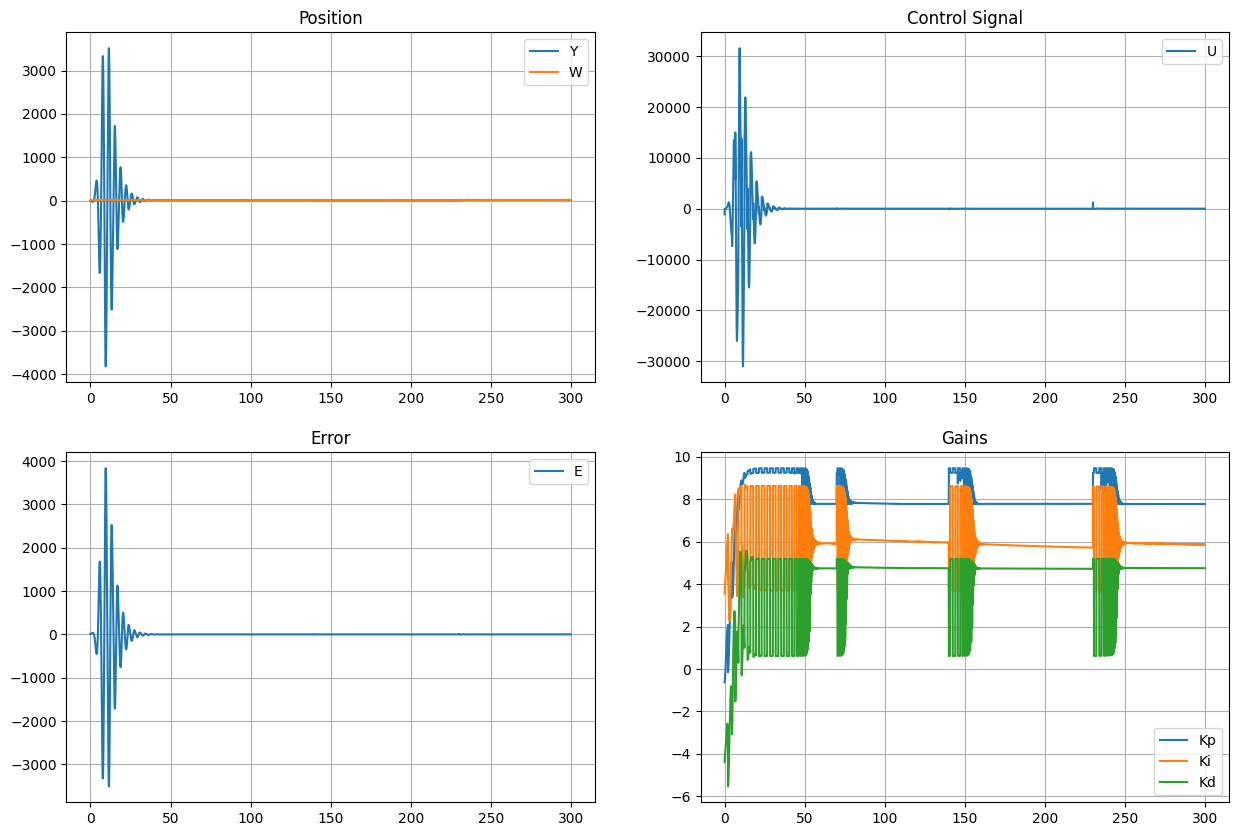

In [29]:
def plot(feedback: Feedback):
    Y = [x.detach().numpy() for x in feedback.Y]
    W = [x.detach().numpy() for x in TARGET]
    U = [x.detach().numpy() for x in feedback.U]
    E = [x.detach().numpy() for x in feedback.E]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(TIME, Y, label='Y')
    axs[0, 0].plot(TIME, W, label='W')
    axs[0, 0].set_title('Position')
    axs[0, 0].legend()
    # axs[0, 0].set_ylim(-25, 25)

    axs[0, 1].plot(TIME, U, label='U')
    axs[0, 1].set_title('Control Signal')
    axs[0, 1].legend()

    axs[1, 0].plot(TIME, E, label='E')
    axs[1, 0].set_title('Error')
    axs[1, 0].legend()
    
    axs[1, 1].plot(TIME, feedback.Kp, label='Kp')
    axs[1, 1].plot(TIME, feedback.Ki, label='Ki')
    axs[1, 1].plot(TIME, feedback.Kd, label='Kd')
    axs[1, 1].set_title('Gains')
    axs[1, 1].legend()
    
    # grid
    for ax in axs.flat:
        ax.grid(True)

plot(feedback)

In [30]:
def validate(model):
    pidnn = model.eval()
    with torch.no_grad():
        probress_bar = tqdm(range(len(TIME)))
        for i in probress_bar:
            W = TARGET[i]
            D = DISTURBANCE[i]
            Y = system.get_position().detach()
            E = W - Y

            # Predict

            KKK = pidnn(torch.tensor([W, Y]))
            Kp, Ki, Kd = KKK * 10
            pid.update_gains(Kp, Ki, Kd)
            U = pid.compute2(E, DT)
            feedback.Kp[i] = Kp
            feedback.Ki[i] = Ki
            feedback.Kd[i] = Kd

            # Store values
            feedback.Y[i] = Y
            feedback.U[i] = U
            feedback.E[i] = E

            system.apply_control(U)

In [31]:
validate(pidnn)

  0%|          | 0/7501 [00:00<?, ?it/s]

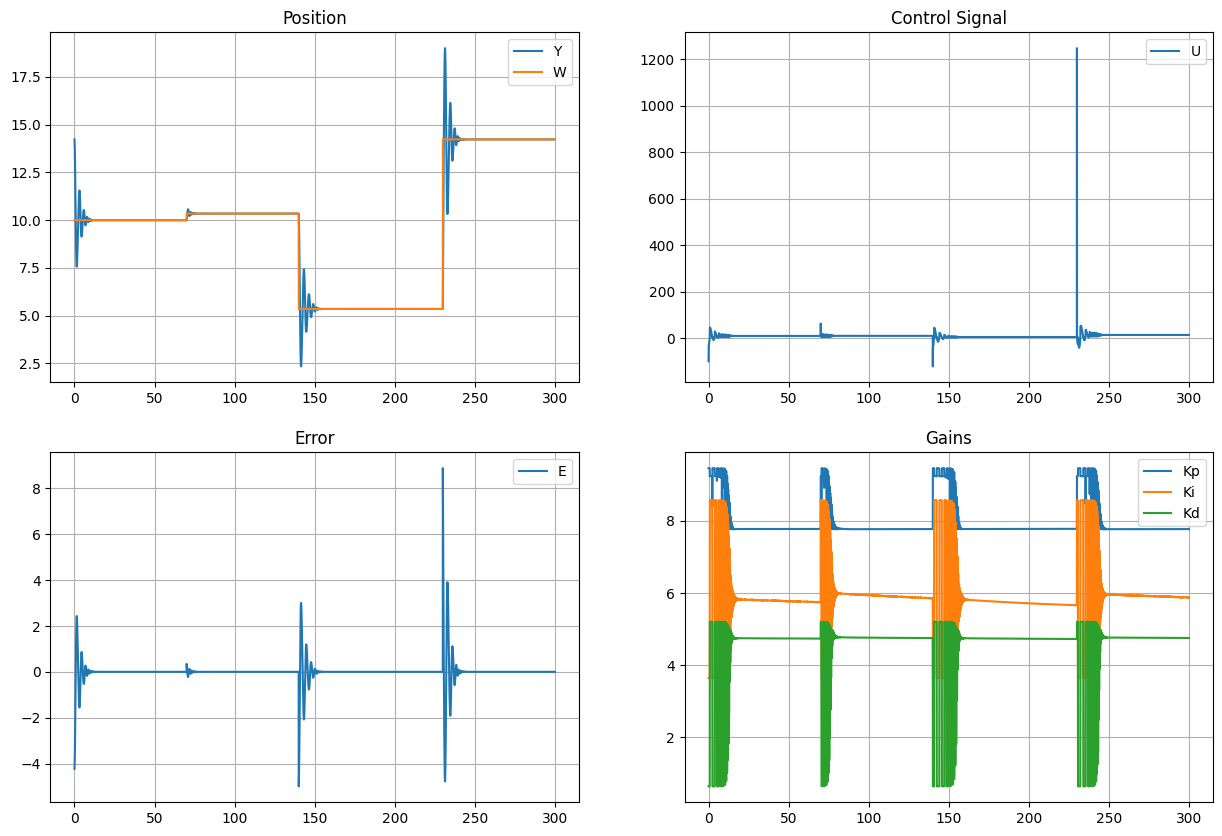

In [33]:
plot(feedback)